In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from adjustText import adjust_text

In [2]:
df = pd.read_csv('filmes_filtrados.csv')

In [3]:
# Convert the 'genres' column to a list of genres
df['genre_names'] = df['genres'].apply(lambda x: x.split('-'))

In [4]:
#display(df[["id", "title", "genre_names"]])

In [5]:
# Explode os gêneros para análises individuais
df_exploded = df.explode('genre_names')

In [6]:
#display(df_exploded.head())

In [7]:
# Calcula a média das notas por gênero
media_por_genero = df_exploded.groupby('genre_names')['vote_average'].mean()

C:\Users\iahuu\AppData\Local\Temp\ipykernel_18020\2769901054.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media.values, y=media.index, palette=colors)


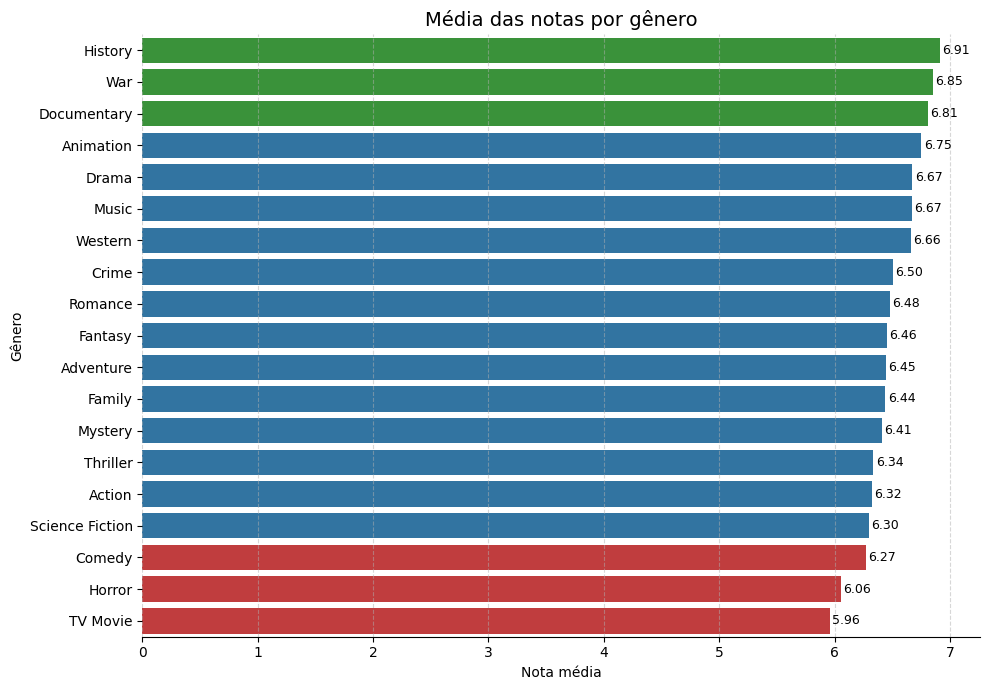

In [8]:
# Ordenar do maior para o menor
media = media_por_genero.sort_values(ascending=False)

# Top 3 e bottom 3 (com base na ordem original)
top_3 = media.head(3).index
bottom_3 = media.tail(3).index

# Lista de cores
colors = [
    '#2ca02c' if g in top_3 else '#d62728' if g in bottom_3 else '#1f77b4'
    for g in media.index
]

# Plot
plt.figure(figsize=(10, 7))
sns.barplot(x=media.values, y=media.index, palette=colors)

# Adiciona as notas ao lado das barras
for i, v in enumerate(media.values):
    plt.text(v + 0.02, i, f"{v:.2f}", va="center", fontsize=9)

# Estética
plt.title('Média das notas por gênero', fontsize=14)
plt.xlabel('Nota média')
plt.ylabel('Gênero')
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=False)
plt.tight_layout()
plt.show()

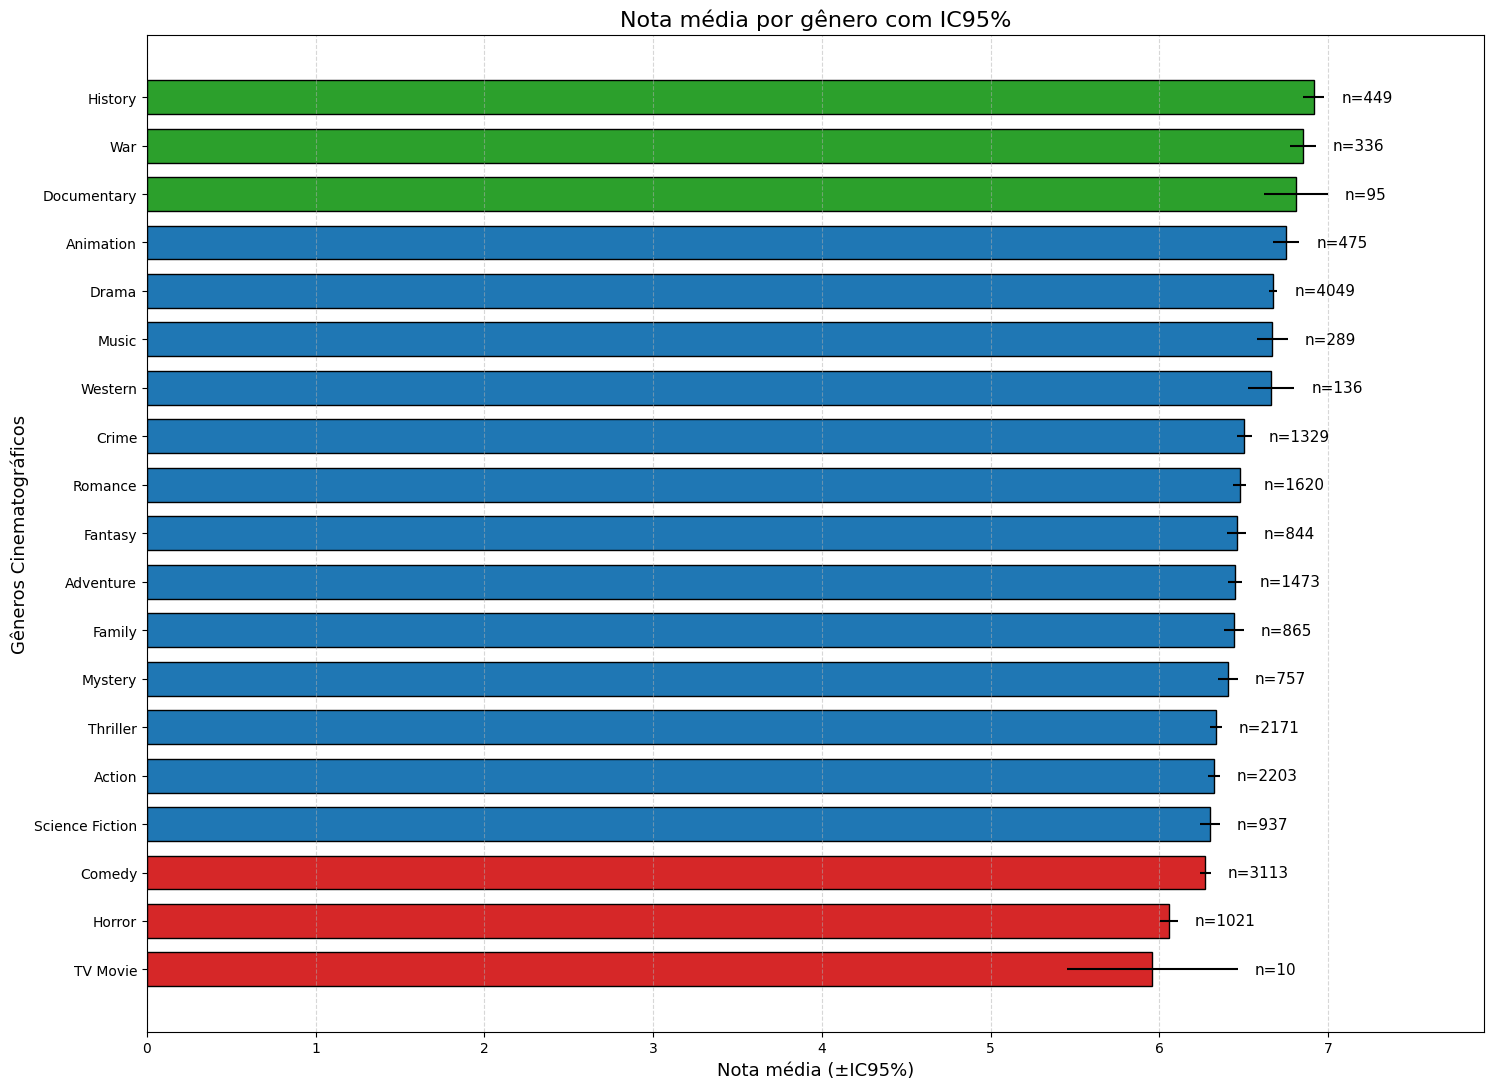

In [9]:
# Calcular médias, contagens e erro padrão por gênero
means = df_exploded.groupby('genre_names')['vote_average'].mean()
counts = df_exploded.groupby('genre_names')['vote_average'].count()
stds = df_exploded.groupby('genre_names')['vote_average'].std()
errs = (stds / counts.pow(0.5)) * 1.96  # IC 95%

# Ordenar por média crescente (de baixo para cima)
means = means.sort_values(ascending=True)

# Redefinir as cores: vermelho para bottom 3 (agora em cima), verde para top 3 (agora embaixo)
colors = [
    '#d62728' if g in bottom_3 else '#2ca02c' if g in top_3 else '#1f77b4'
    for g in means.index
]
errs = errs[means.index]
counts = counts[means.index]

# Usar a lista de cores já definida para destacar top 3 e bottom 3
plt.figure(figsize=(16, 11))
bars = plt.barh(means.index, means.values, xerr=errs.values, color=colors, edgecolor='k', height=0.7)

# Ajuste do deslocamento e limite do eixo x
max_mean = means.values.max()
max_err = errs.values.max()
plt.xlim(right=max_mean + max_err + 0.5)  # margem extra

for i, (mean, count, err) in enumerate(zip(means.values, counts.values, errs.values)):
    plt.text(mean + err + 0.1, i, f"n={count}", va='center', fontsize=11)

plt.xlabel('Nota média (±IC95%)', fontsize=13)
plt.ylabel('Gêneros Cinematográficos', fontsize=13)
plt.title('Nota média por gênero com IC95%', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout(rect=[0, 0, 0.94, 1])
plt.show()

C:\Users\iahuu\AppData\Local\Temp\ipykernel_18020\2826712531.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


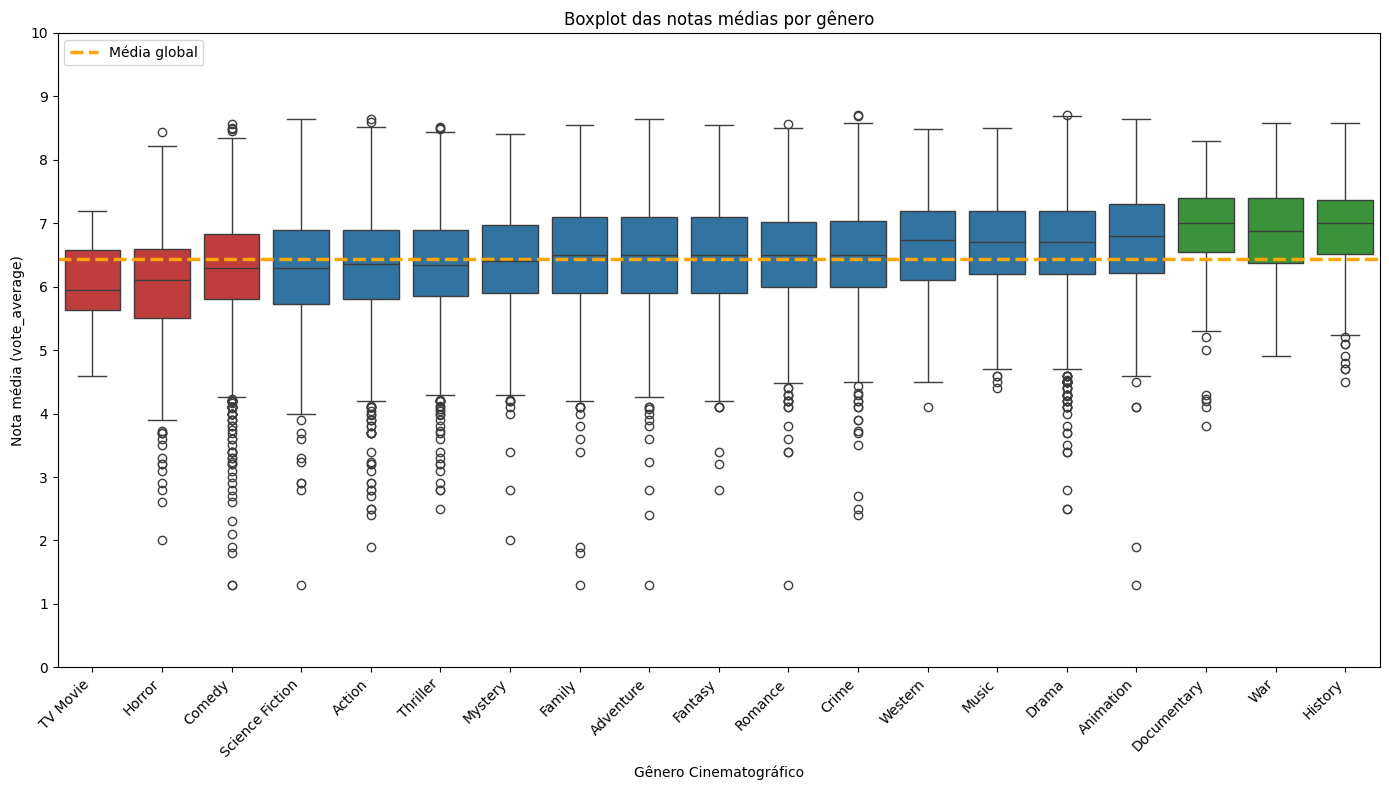

In [11]:
# Definir a média global das notas
media_global = df['vote_average'].mean()

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_exploded,
    x='genre_names',
    y='vote_average',
    order=means.index,
    palette=colors
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Gênero Cinematográfico')

plt.axhline(media_global, color='orange', linestyle='--', linewidth=2.5, label='Média global')

plt.text(
    len(means) - 0.5, media_global + 0.05,
    '',
    color='orange', fontsize=12, fontweight='bold', va='bottom', ha='right', backgroundcolor='white'
)

plt.ylabel('Nota média (vote_average)')
plt.title('Boxplot das notas médias por gênero')
plt.legend(loc='upper left')

plt.ylim(bottom=0)
plt.yticks(np.arange(0, 11, 1))  # eixo y de 1 em 1, até 10
plt.tight_layout()
plt.show()


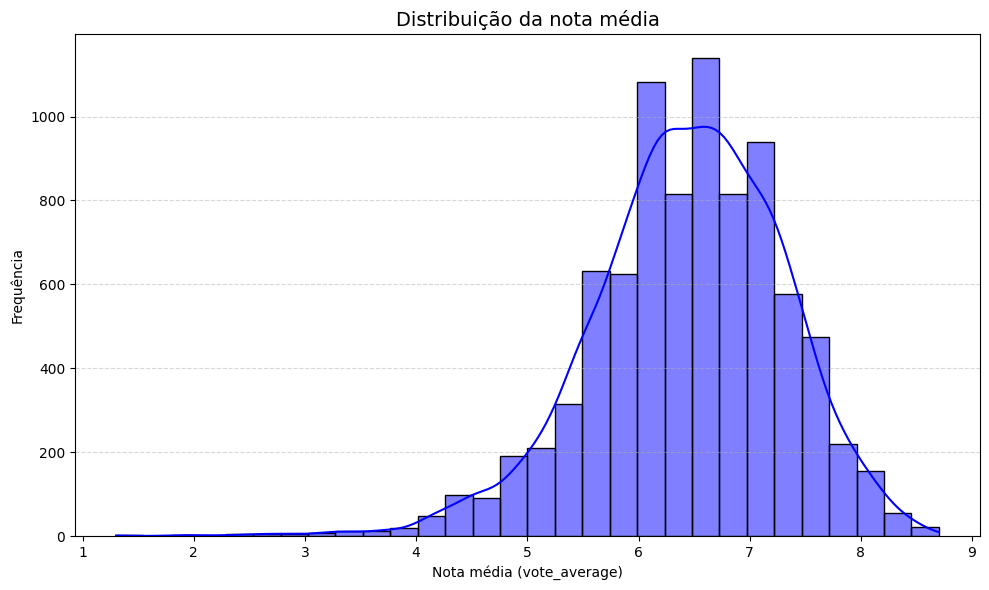

Estatística do teste: 0.9825, p-valor: 0.0000
As notas dos filmes não seguem uma distribuição normal (rejeitamos H0).


c:\Users\iahuu\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8581.
  res = hypotest_fun_out(*samples, **kwds)


In [12]:
# Histograma e gráfico de densidade
plt.figure(figsize=(10, 6))
sns.histplot(df['vote_average'], kde=True, bins=30, color='blue')
plt.title('Distribuição da nota média', fontsize=14)
plt.xlabel('Nota média (vote_average)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Teste de normalidade Shapiro-Wilk
stat, p = shapiro(df['vote_average'])
print(f"Estatística do teste: {stat:.4f}, p-valor: {p:.4f}")

# Interpretação do p-valor
if p > 0.05:
    print("As notas dos filmes seguem uma distribuição normal (não rejeitamos H0).")
else:
    print("As notas dos filmes não seguem uma distribuição normal (rejeitamos H0).")

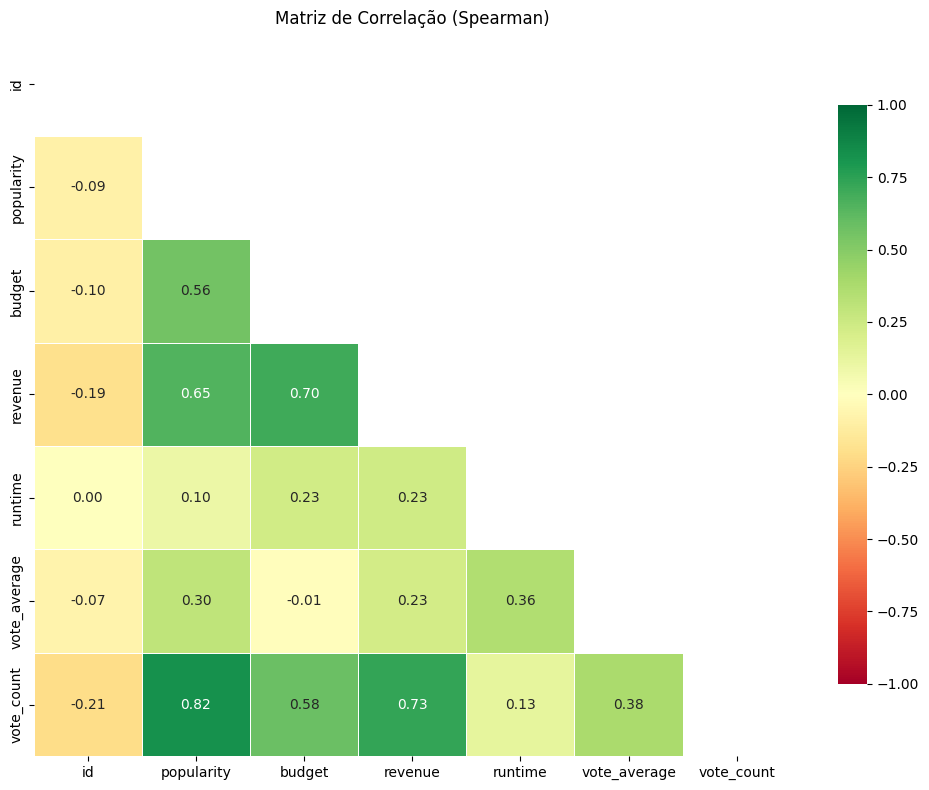

In [14]:
# Calcula a matriz de correlação de Spearman apenas com colunas numéricas
correlacao = df.corr(method='spearman', numeric_only=True)
# Cria a máscara para a parte superior
mask = np.triu(np.ones_like(correlacao, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlacao,
    mask=mask,
    cmap='RdYlGn',
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": .8},
    vmin=-1,
    vmax=1,
    center=0
)

plt.title("Matriz de Correlação (Spearman)")
plt.tight_layout()
plt.show()


In [ ]:
# Análise da relação negativa entre 'budget' e 'vote_average'

# Primeiro, vamos verificar a correlação exata entre 'budget' e 'vote_average'
correlacao_budget_vote = df[['budget', 'vote_average']].corr(method='spearman').iloc[0, 1]
print(f"Correlação de Spearman entre budget e vote_average: {correlacao_budget_vote:.3f}")

# Visualização da relação
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='budget', y='vote_average', alpha=0.5)
plt.xlabel('Budget')
plt.ylabel('Nota média (vote_average)')
plt.title('Relação entre Budget e Nota Média')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Análise textual
print(
    "A correlação negativa sugere que, em média, filmes com orçamentos maiores tendem a ter notas médias ligeiramente menores. "
    "Isso pode ocorrer porque grandes produções muitas vezes buscam agradar a um público mais amplo, resultando em obras menos inovadoras ou arriscadas, "
    "enquanto filmes de orçamento menor podem ser mais autorais e receber avaliações mais altas de nichos críticos. "
    "Além disso, orçamentos elevados não garantem qualidade artística ou aprovação do público/da crítica."
)